In [205]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree
from sympy import flatten


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *
from lib.som_training import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values



        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]


In [207]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []


feature_type_1 = 'permutation_angle_0_75_dist'
feature_type_2 = 'permutation'

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    # print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        # print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
        
    features_1 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_1)
    features_2 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_2)
    
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    # print('features_1: ', features_1)
    # print('features_2: ', features_2)

    # print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    # print('----------------------')

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min()) / (star_features.max() - star_features.min())
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

print("Features 1 shape: ", features_1_n.shape)
print("Features 2 shape: ", features_2_n.shape)

# Print example of the features
print("Example of the features: ")
print("Features 1: ", features_vec_1[0])
print("Features 2: ", features_vec_2[0])

norm_param = [features_vec_1.min(), features_vec_1.max(), features_vec_2.min(), features_vec_2.max()]
# norm_param = [features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)]
print("Normalization parameters: ", norm_param)

Features 1 shape:  (4566, 10)
Features 2 shape:  (4566, 10)
Example of the features: 
Features 1:  [ 0.85662  12.96504  1.13140  0.76207  2.58149  6.33714  6.63224  3.60156
  3.35006  2.10104]
Features 2:  [ 0.26403  3.61404  4.33014  4.72649  3.41433  4.35828  4.73313  3.71788
  3.68960  0.53448]
Normalization parameters:  [8.721198580624508e-09, 76.81085042607027, 0.00023482725329105708, 26.108626045111873]


In [208]:
# ---------------------------------------------------------------------------- #
# --------------------------------- LOAD SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #
import pickle

mesh_size = 80
catalog_filter = 6
name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)

name = 'acc97_n89_89_tycho6_permutation_angle_0_75_dist_permutation'
# name = 'acc97_n89_89_tycho6_permutation_multi_permutation'

#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

with open(f'../data/SOM_parameters/{name}/index_{name}.p', 'rb') as infile:
    indices = pickle.load(infile)


In [209]:
import time 
from lib.event_processing import predict_star_id, check_star_id_by_neight


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])

# Pixel scaled noise
# noise = generate_pixel_noise(stars_data.shape, 10)
noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, 5)
mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
stars_pos += noise

mean_time = 0

time_start = time.time()

som1_activate_data = []
som2_activate_data = []

features_1_noisy = []
features_2_noisy = []

correct_ids = []
predicted_ids = []

for i in range(len(stars_pos)):
    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1_noisy.append(features_1) 
    features_2_noisy.append(features_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)


    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2
    
    predicted_ids.append(star_guess[0] if star_guess else 0)

    # Accuracy count
    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1

    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
        if star_guess[0] == i:
            correct_ids.append(i)
    else:
        # print("Error: ", list(set(winner_ids_1).intersection(winner_ids_2)), "!=", i)
        if len(star_guess) == 0: # If no match

            if i in winner_ids_1:
                cont[3] += 1
            elif i in winner_ids_2:
                cont[4] += 1
            else:  
                cont[5] += 1

            # print("gt:", i)
            # print("ids 1:", winner_ids_1, "activation: ", act_som1.min() ) 
            # print("ids 2:", winner_ids_2, "activation: ", act_som2.min() )
            # print('----------------------')

            if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                if i in winner_ids_1 and act_som1.min() < act_som2.min():
                    cont_no_match[0] += 1
                elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                    cont_no_match[1] += 1
                else:
                    cont_no_match[2] += 1
                


        cont[2] += len(star_guess) > 1
time_end = time.time()


print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
print(f"total success = {cont[0:6] / stars_pos.shape[0]} = {np.sum(cont[0:6]) / stars_pos.shape[0]}")
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
# print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])


Std pixels:  0.05859375
number of cases: 4566.0 len:  4566
mean noise level= 0.07297344490520805 noise example:  [-0.08879  0.12723]
total success = [ 0.97569  0.01774  0.00613  0.00000  0.00044  0.00000] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.966053438458169  SOM2 success: 0.993867717915024
total time= 4.653513669967651
total time per star= 0.001019166375376183


# Apply confirmation and extend the presictions

In [217]:
# Apliying the check_star_id_by_neight function to correct the star ids
'''For thesting the whole dataset all the sky is treated as a single frame.
This way, we can update the wrongly predicted results in the original neighbour 
set and directly send all the stars to the function 
-ground truth: Ground truth of the predicted ids
img_index: Original neighbour set with the updated wrong predictions
indices: Order of the stars in the original dataset = indices'''

wrong_index = np.where(predicted_ids != np.arange(0, len(stars_data)) ) [0]
img_index = np.copy(indices)

# Update the wrong predicted values in the gt 
for ind in wrong_index: 
        img_index[img_index == ind] = predicted_ids[ind]

print('wrong predictions:', wrong_index.shape)

confirmed_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = False)
extended_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = True)

acc_init = np.sum(np.arange(0, len(stars_data)) == predicted_ids) / len(stars_data)
final_acc = np.sum(np.arange(0, len(stars_data)) == confirmed_ids) / len(stars_data)
extended_acc = np.sum(np.arange(0, len(stars_data)) == extended_ids) / len(stars_data)

corrected_stars = len(stars_data) - np.sum( extended_ids == predicted_ids) 

print(f"----------------- RESULTS Before CORRECTION -----------------")
print(f" success = [{acc_init},{1-acc_init}]")

print(f"----------------- RESULTS AFTER CORRECTION -----------------")
print(f"Not extended = [{final_acc},{1-final_acc}]")
print(f"Extended     = [{extended_acc},{1-extended_acc}]")
print("               ", "[ CORRECT  ,   WRONG  ]")
print(f'Corrected stars: {corrected_stars} of {len(stars_data)} ; {corrected_stars/len(stars_data)}')

wrong predictions: (100,)
----------------- RESULTS Before CORRECTION -----------------
 success = [0.9780989925536575,0.02190100744634249]
----------------- RESULTS AFTER CORRECTION -----------------
Not extended = [0.977879982479194,0.022120017520805946]
Extended     = [0.9973718791064389,0.0026281208935611255]
                [ CORRECT  ,   WRONG  ]
Corrected stars: 96 of 4566 ; 0.02102496714848883


In [ ]:
# Check and print the wrong predicted stars to see the errors

for ind in np.where(confirmed_ids != np.arange(0, len(stars_data)) ) [0]:
    print(f"Star ID: {ind} - Predicted ID: {predicted_ids[ind]} - Confirmed ID: {confirmed_ids[ind]}")
    print(f"neighbors gt: {indices[ind]} - neighbors pred: {img_index[ind]} ")
    print(f"neighbors gt: {indices[np.where(img_index == predicted_ids[ind])[0]]} \n - neighbors pred: {img_index[np.where(img_index == predicted_ids[ind])[0]]} ")

# Get values for ploting 

In [251]:
import time 
from lib.event_processing import predict_star_id
from tqdm import tqdm

max_pixel_std = 16

results_vec = []
for n_to_avg in tqdm(range(5)):
    results = []
    for n_pixels in range(max_pixel_std):


        cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
        cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
        acc = np.zeros(2) # [correct SOM1, correct SOM2]

        stars_pos = np.copy(stars_data[:,1:3])

        # Pixel scaled noise
        # noise = generate_pixel_noise(stars_data.shape, n_pixels)
        noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, n_pixels)

        mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
        stars_pos += noise

        mean_time = 0

        time_start = time.time()

        som1_activate_data = []
        som2_activate_data = []

        features_1_noisy = []
        features_2_noisy = []

        predicted_ids = []

        for i in range(len(stars_pos)):
            features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
            features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
                
            # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
            # feature_type_1 = 'permutation_multi'
            # feature_type_2 = 'permutation'

            features_1_noisy.append(features_1) 
            features_2_noisy.append(features_2)

            winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
            winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

            if i in winner_ids_1 and len(winner_ids_1) < 20:
                acc[0] += 1
            if i in winner_ids_2 and len(winner_ids_2) < 20:
                acc[1] += 1
            

            if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
                star_guess = winner_ids_2
            elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
                star_guess = winner_ids_1
            else:
                star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

            if len(star_guess) == 0: # Second guees 
                if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
                    star_guess = (winner_ids_1)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
                    star_guess = (winner_ids_2)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
                    act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
                    act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
                    if act_som1.min() < act_som2.min():
                        star_guess = winner_ids_1
                    else:
                        star_guess = winner_ids_2

            predicted_ids.append(star_guess[0] if star_guess else 0)

            # Accuracy count
            if len(star_guess) == 1:
                cont[0] += star_guess[0] == i
                cont[1] += star_guess[0] != i
            else:
                cont[1] += len(star_guess) 

        # Apply verification
        time_end = time.time()

        wrong_index = np.where(predicted_ids != np.arange(0, len(stars_data)) ) [0]
        img_index = np.copy(indices)

        # Update the wrong predicted values in the gt 
        for ind in wrong_index: 
                img_index[img_index == ind] = predicted_ids[ind]

        confirmed_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = False)
        extended_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = True)

        acc_init = np.sum(np.arange(0, len(stars_data)) == predicted_ids) / len(stars_data)
        final_acc = np.sum(np.arange(0, len(stars_data)) == confirmed_ids) / len(stars_data)
        extended_acc = np.sum(np.arange(0, len(stars_data)) == extended_ids) / len(stars_data)

        corrected_stars = len(stars_data) - np.sum( extended_ids == predicted_ids) 

        # print('number of cases:', np.sum(cont[0:-1]), 'len: ', len(stars_pos))
        # print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
        # np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
        # print(f"total success = {cont[0:-1] / stars_pos.shape[0]} = {np.sum(cont[0:-1]) / stars_pos.shape[0]}")
        # print("               ", "[ CORRECT  ,   WRONG  ]")
        # print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
        # # print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
        # print("total time=",  time_end - time_start)
        # print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

        # Save the results in a list variable
        results.append( [ cont[0:-1] / stars_pos.shape[0], acc / stars_pos.shape[0],acc_init, final_acc,extended_acc, corrected_stars] )
    results_vec.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

Std pixels:  0.0
Std pixels:  0.01171875
Std pixels:  0.0234375
Std pixels:  0.03515625
Std pixels:  0.046875
Std pixels:  0.05859375
Std pixels:  0.0703125
Std pixels:  0.08203125
Std pixels:  0.09375
Std pixels:  0.10546875
Std pixels:  0.1171875
Std pixels:  0.12890625
Std pixels:  0.140625
Std pixels:  0.15234375
Std pixels:  0.1640625
Std pixels:  0.17578125


 20%|██        | 1/5 [01:30<06:00, 90.20s/it]

Std pixels:  0.0
Std pixels:  0.01171875
Std pixels:  0.0234375
Std pixels:  0.03515625
Std pixels:  0.046875
Std pixels:  0.05859375
Std pixels:  0.0703125
Std pixels:  0.08203125
Std pixels:  0.09375
Std pixels:  0.10546875
Std pixels:  0.1171875
Std pixels:  0.12890625
Std pixels:  0.140625
Std pixels:  0.15234375
Std pixels:  0.1640625
Std pixels:  0.17578125


 40%|████      | 2/5 [03:06<04:41, 93.98s/it]

Std pixels:  0.0
Std pixels:  0.01171875
Std pixels:  0.0234375
Std pixels:  0.03515625
Std pixels:  0.046875
Std pixels:  0.05859375
Std pixels:  0.0703125
Std pixels:  0.08203125
Std pixels:  0.09375
Std pixels:  0.10546875
Std pixels:  0.1171875
Std pixels:  0.12890625
Std pixels:  0.140625
Std pixels:  0.15234375
Std pixels:  0.1640625
Std pixels:  0.17578125


 60%|██████    | 3/5 [04:36<03:03, 91.82s/it]

Std pixels:  0.0
Std pixels:  0.01171875
Std pixels:  0.0234375
Std pixels:  0.03515625
Std pixels:  0.046875
Std pixels:  0.05859375
Std pixels:  0.0703125
Std pixels:  0.08203125
Std pixels:  0.09375
Std pixels:  0.10546875
Std pixels:  0.1171875
Std pixels:  0.12890625
Std pixels:  0.140625
Std pixels:  0.15234375
Std pixels:  0.1640625
Std pixels:  0.17578125


 80%|████████  | 4/5 [05:57<01:27, 87.52s/it]

Std pixels:  0.0
Std pixels:  0.01171875
Std pixels:  0.0234375
Std pixels:  0.03515625
Std pixels:  0.046875
Std pixels:  0.05859375
Std pixels:  0.0703125
Std pixels:  0.08203125
Std pixels:  0.09375
Std pixels:  0.10546875
Std pixels:  0.1171875
Std pixels:  0.12890625
Std pixels:  0.140625
Std pixels:  0.15234375
Std pixels:  0.1640625
Std pixels:  0.17578125


100%|██████████| 5/5 [07:18<00:00, 87.61s/it]


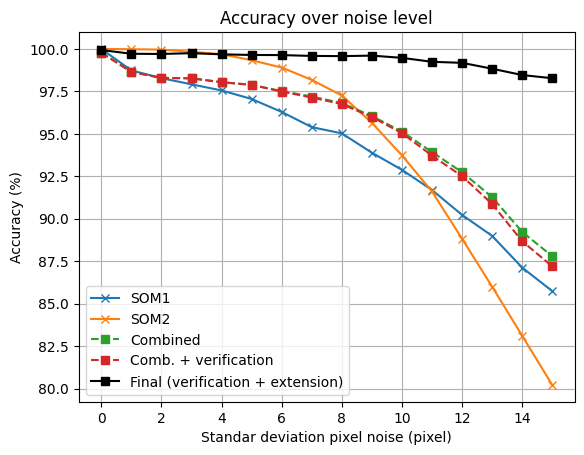

In [261]:
average_results = np.mean(np.array(results_vec, dtype=object) , axis=0)

std_axis = np.arange(max_pixel_std) 

plt.figure()
plt.plot(std_axis, [x[1][0]*100 for x in average_results], label='SOM1', marker='x', )
plt.plot(std_axis, [x[1][1]*100 for x in average_results], label='SOM2', marker='x', )
plt.plot(std_axis, [x[2]*100 for x in average_results], label='Combined',linestyle='--', marker='s')
plt.plot(std_axis, [x[3]*100 for x in average_results], label='Comb. + verification', marker='s', linestyle='--')
plt.plot(std_axis, [x[4]*100 for x in average_results], label='Final (verification + extension)', marker='s', color='black')

# Include grid 
plt.grid( which='both', axis='both')

plt.title('Accuracy over noise level')
plt.xlabel('Standar deviation pixel noise (pixel)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


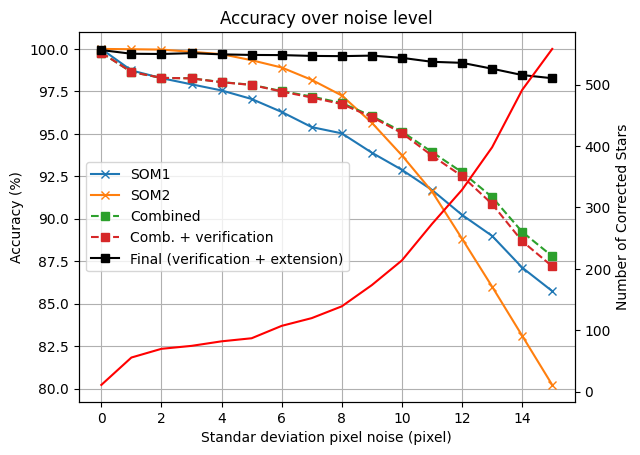

In [265]:
# Create the figure and the primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(std_axis, [x[1][0]*100 for x in average_results], label='SOM1', marker='x')
ax1.plot(std_axis, [x[1][1]*100 for x in average_results], label='SOM2', marker='x')
ax1.plot(std_axis, [x[2]*100 for x in average_results], label='Combined', linestyle='--', marker='s')
ax1.plot(std_axis, [x[3]*100 for x in average_results], label='Comb. + verification', marker='s', linestyle='--')
ax1.plot(std_axis, [x[4]*100 for x in average_results], label='Final (verification + extension)', marker='s', color='black')

# Include grid for the primary y-axis
ax1.grid(which='both', axis='both')

# Configure the labels and title for the primary y-axis
ax1.set_title('Accuracy over noise level')
ax1.set_xlabel('Standar deviation pixel noise (pixel)')
ax1.set_ylabel('Accuracy (%)')

# Add a legend for the primary y-axis
ax1.legend(loc='center left')

# Create a secondary y-axis (right y-axis) that shares the same x-axis
ax2 = ax1.twinx()

# Plot the data for the secondary y-axis
ax2.plot(std_axis, [x[5] for x in average_results], color='red')

# Configure the label for the secondary y-axis
ax2.set_ylabel('Number of Corrected Stars')

# Display the plot
plt.show()


Copy values to plot performace plots

In [256]:
print('combined', [x[2]*100 for x in average_results][0:6])
print('combined (verification)', [x[3]*100 for x in average_results][0:6])
print('combined (verification + extension)', [x[4]*100 for x in average_results][0:6])

print('SOM1 acc', [x[1][0]*100 for x in average_results][10])
print('SOM2 acc', [x[1][1]*100 for x in average_results][10])

combined [99.78098992553657, 98.64213753832675, 98.29610162067455, 98.26982041173893, 98.04643013578624, 97.88874288217258]
combined (verification) [99.78098992553657, 98.64213753832675, 98.29610162067455, 98.26544021024966, 98.03766973280771, 97.87998247919404]
combined (verification + extension) [99.93429697766099, 99.71528690319754, 99.70214629872973, 99.7503285151117, 99.68024529128341, 99.64520367936926]
SOM1 acc 92.88217257993867
SOM2 acc 93.73193166885677


# False stars 

In [324]:
1440 / 5

288.0

In [349]:
864*5

4320

In [350]:
from lib.som_training import generate_false_stars

stars_pos = np.copy(stars_data[:,1:3])

n_false_stars = 1
false_stars = generate_false_stars(360, 180)
for i in range(n_false_stars-1):
    false_stars = np.append(false_stars, generate_false_stars(360, 180), axis=0)

false_stars[:,1] -= 90 # Set +-90 range 
stars_pos = np.append(stars_pos, false_stars, axis=0)


n_of_neighbor = 4
tree = KDTree(stars_pos)
_, indices = tree.query(stars_pos, k=n_of_neighbor+1)

print('False stars:', false_stars.shape)
print('Stars pos:', stars_pos.shape)
print('original stars:', stars_data.shape)
print('percentage of false stars:', false_stars.shape[0] / stars_data.shape[0])


False stars: (288, 2)
Stars pos: (4854, 2)
original stars: (4566, 3)
percentage of false stars: 0.06307490144546649


In [332]:
import time 

from tqdm import tqdm


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])


n_false_stars = 1
false_stars = generate_false_stars(360, 180)
for i in range(n_false_stars-1):
    false_stars = np.append(false_stars, generate_false_stars(360, 180), axis=0)

false_stars[:,1] -= 90 # Set +-90 range 
stars_pos = np.append(stars_pos, false_stars, axis=0)


n_of_neighbor = 4
tree = KDTree(stars_pos)
_, indices = tree.query(stars_pos, k=n_of_neighbor+1)

# Pixel scaled noise
# noise = generate_pixel_noise(stars_data.shape, n_pixels)
# noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, n_pixels)
# mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
# stars_pos += noise

mean_time = 0
time_start = time.time()

som1_activate_data = []
som2_activate_data = []

features_1_noisy = []
features_2_noisy = []

predicted_ids = []

for i in range(stars_pos.shape[0]):
    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1_noisy.append(features_1) 
    features_2_noisy.append(features_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    

    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2

    predicted_ids.append(star_guess[0] if star_guess else 0)

    # Accuracy count
    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        cont[1] += len(star_guess) 



In [333]:
# Apliying the check_star_id_by_neight function to correct the star ids
'''For thesting the whole dataset all the sky is treated as a single frame.
This way, we can update the wrongly predicted results in the original neighbour 
set and directly send all the stars to the function 
-ground truth: Ground truth of the predicted ids
img_index: Original neighbour set with the updated wrong predictions
indices: Order of the stars in the original dataset = indices'''

wrong_index = np.where(predicted_ids != indices[:,0] ) [0]
img_index = np.copy(indices)

# Update the wrong predicted values in the gt 
for ind in wrong_index: 
        img_index[img_index == ind] = predicted_ids[ind]

print('wrong predictions:', wrong_index.shape)

confirmed_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = False)
extended_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = True)

acc_init = np.sum(indices[:,0] == predicted_ids) / len(stars_data)
final_acc = np.sum(indices[:,0]== confirmed_ids) / len(stars_data)
extended_acc = np.sum(indices[:,0] == extended_ids) / len(stars_data)

corrected_stars = len(stars_data) - np.sum( extended_ids == predicted_ids) 

print(f"----------------- RESULTS Before CORRECTION -----------------")
print(f" success = [{acc_init},{1-acc_init}]")

print(f"----------------- RESULTS AFTER CORRECTION -----------------")
print(f"Not extended = [{final_acc},{1-final_acc}]")
print(f"Extended     = [{extended_acc},{1-extended_acc}]")
print("               ", "[ CORRECT  ,   WRONG  ]")
print(f'Corrected stars: {corrected_stars} of {len(stars_data)} ; {corrected_stars/len(stars_data)}')

wrong predictions: (1217,)
----------------- RESULTS Before CORRECTION -----------------
 success = [0.7965396408234778,0.20346035917652217]
----------------- RESULTS AFTER CORRECTION -----------------
Not extended = [0.7877792378449409,0.21222076215505914]
Extended     = [0.932544897065265,0.067455102934735]
                [ CORRECT  ,   WRONG  ]
Corrected stars: 943 of 4566 ; 0.20652650021901006


In [317]:
for i in range(0):
    print('Star ID:', i)

In [334]:
import time 
from tqdm import tqdm

false_stars_max = 5

results_vec = []
for n_to_avg in tqdm(range(5)):
    results = []
    for n_false_stars in range(false_stars_max):

        cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
        cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
        acc = np.zeros(2) # [correct SOM1, correct SOM2]

        stars_pos = np.copy(stars_data[:,1:3])

        if n_false_stars > 0:
            false_stars = generate_false_stars(360, 180)
            for i in range(n_false_stars-1):
                false_stars = np.append(false_stars, generate_false_stars(360, 180), axis=0)

            false_stars[:,1] -= 90 # Set +-90 range 
            stars_pos = np.append(stars_pos, false_stars, axis=0)


        n_of_neighbor = 4
        tree = KDTree(stars_pos)
        _, indices = tree.query(stars_pos, k=n_of_neighbor+1)

        # Pixel scaled noise
        # noise = generate_pixel_noise(stars_data.shape, n_pixels)
        # noise = generate_gaussian_pixel_noise(stars_data[:,0:2].shape, n_pixels)
        # mean_noise = np.mean( np.linalg.norm(stars_data[:,1:3]-(stars_pos+noise), axis=1))
        # stars_pos += noise

        mean_time = 0
        time_start = time.time()

        som1_activate_data = []
        som2_activate_data = []

        features_1_noisy = []
        features_2_noisy = []

        predicted_ids = []

        for i in range(stars_pos.shape[0]):
            features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
            features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)
                
            # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
            # feature_type_1 = 'permutation_multi'
            # feature_type_2 = 'permutation'

            features_1_noisy.append(features_1) 
            features_2_noisy.append(features_2)

            winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
            winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

            if i in winner_ids_1 and len(winner_ids_1) < 20:
                acc[0] += 1
            if i in winner_ids_2 and len(winner_ids_2) < 20:
                acc[1] += 1
            

            if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
                star_guess = winner_ids_2
            elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
                star_guess = winner_ids_1
            else:
                star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

            if len(star_guess) == 0: # Second guees 
                if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
                    star_guess = (winner_ids_1)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
                    star_guess = (winner_ids_2)
                elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
                    act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
                    act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
                    if act_som1.min() < act_som2.min():
                        star_guess = winner_ids_1
                    else:
                        star_guess = winner_ids_2

            predicted_ids.append(star_guess[0] if star_guess else 0)

            # Accuracy count
            if len(star_guess) == 1:
                cont[0] += star_guess[0] == i
                cont[1] += star_guess[0] != i
            else:
                cont[1] += len(star_guess) 

        # Apply verification
        time_end = time.time()

        wrong_index = np.where(predicted_ids != indices[:,0] ) [0]
        img_index = np.copy(indices)

        # Update the wrong predicted values in the gt 
        for ind in wrong_index: 
                img_index[img_index == ind] = predicted_ids[ind]

        print('wrong predictions:', wrong_index.shape)

        confirmed_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = False)
        extended_ids, _= check_star_id_by_neight(indices[predicted_ids], img_index, indices, extend_puzzle = True)

        acc_init = np.sum(indices[:,0] == predicted_ids) / len(stars_data)
        final_acc = np.sum(indices[:,0]== confirmed_ids) / len(stars_data)
        extended_acc = np.sum(indices[:,0] == extended_ids) / len(stars_data)

        corrected_stars = len(stars_data) - np.sum( extended_ids == predicted_ids) 

        # print('number of cases:', np.sum(cont[0:-1]), 'len: ', len(stars_pos))
        # print("mean noise level=",  mean_noise, 'noise example: ', stars_data[0][1:3]-stars_pos[0])
        # np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
        # print(f"total success = {cont[0:-1] / stars_pos.shape[0]} = {np.sum(cont[0:-1]) / stars_pos.shape[0]}")
        # print("               ", "[ CORRECT  ,   WRONG  ]")
        # print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
        # # print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
        # print("total time=",  time_end - time_start)
        # print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

        # Save the results in a list variable
        results.append( [ cont[0:-1] / stars_pos.shape[0], acc / stars_pos.shape[0],acc_init, final_acc,extended_acc, corrected_stars] )
    results_vec.append(results)

  0%|          | 0/5 [00:00<?, ?it/s]

wrong predictions: (10,)
wrong predictions: (1246,)
wrong predictions: (2183,)
wrong predictions: (2918,)


 20%|██        | 1/5 [00:31<02:07, 31.89s/it]

wrong predictions: (3548,)
wrong predictions: (10,)
wrong predictions: (1261,)
wrong predictions: (2185,)
wrong predictions: (2903,)


 40%|████      | 2/5 [01:14<01:53, 37.97s/it]

wrong predictions: (3505,)
wrong predictions: (10,)
wrong predictions: (1255,)
wrong predictions: (2136,)
wrong predictions: (2933,)


 60%|██████    | 3/5 [01:50<01:14, 37.30s/it]

wrong predictions: (3562,)
wrong predictions: (10,)
wrong predictions: (1246,)
wrong predictions: (2203,)
wrong predictions: (2918,)


 80%|████████  | 4/5 [02:23<00:35, 35.60s/it]

wrong predictions: (3549,)
wrong predictions: (10,)
wrong predictions: (1177,)
wrong predictions: (2202,)
wrong predictions: (2935,)


100%|██████████| 5/5 [02:56<00:00, 35.34s/it]

wrong predictions: (3567,)


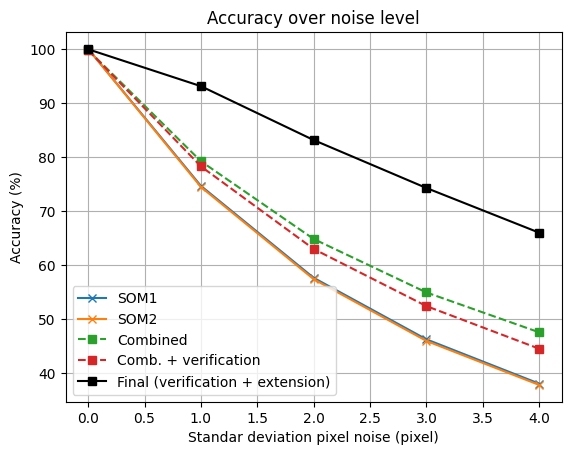

In [337]:
average_results = np.mean(np.array(results_vec, dtype=object) , axis=0)

std_axis = np.arange(false_stars_max) 

plt.figure()
plt.plot(std_axis, [x[1][0]*100 for x in average_results], label='SOM1', marker='x', )
plt.plot(std_axis, [x[1][1]*100 for x in average_results], label='SOM2', marker='x', )
plt.plot(std_axis, [x[2]*100 for x in average_results], label='Combined',linestyle='--', marker='s')
plt.plot(std_axis, [x[3]*100 for x in average_results], label='Comb. + verification', marker='s', linestyle='--')
plt.plot(std_axis, [x[4]*100 for x in average_results], label='Final (verification + extension)', marker='s', color='black')

# Include grid 
plt.grid()

plt.title('Accuracy over noise level')
plt.xlabel('Standar deviation pixel noise (pixel)')
plt.ylabel('Accuracy (%)')
plt.legend(loc='lower left')
plt.show()


In [338]:
print('combined', [x[2]*100 for x in average_results][0:6])
print('combined (verification)', [x[3]*100 for x in average_results][0:6])
print('combined (verification + extension)', [x[4]*100 for x in average_results][0:6])



combined [99.78098992553657, 79.21594393342095, 64.83136224266316, 54.94086727989488, 47.56460797196671]
combined (verification) [99.78098992553657, 78.26544021024966, 62.98291721419184, 52.41349102058695, 44.529128339903636]
combined (verification + extension) [99.93429697766099, 93.10556285589136, 83.13622426631626, 74.26631625054753, 66.00087604029787]


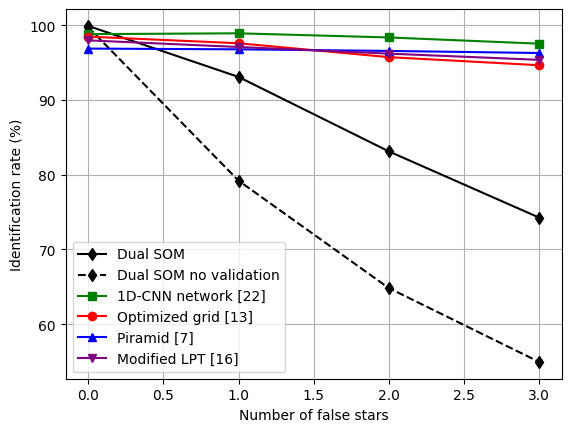

In [344]:

dual_SOM = [x[4]*100 for x in average_results][0:6]
dual_SOM_nv = [x[2]*100 for x in average_results][0:6]
modified_lpt = [98, 97.1135343795555, 96.22539111172642, 95.39275679813667, 93.67197921671783, 91.78467477258106]
optimiced_grid = [98.5, 97.61311496770936, 95.75356500069223, 94.67114039302555, 92.8948538573674, 90.6744956877947]
d1_CNN_network = [98.83431196097433, 98.94532986945298, 98.3902403270598, 97.55760601347004, 97.4465881049914, 97.39107915075209]
piramid = [96.9, 96.8, 96.586199314282, 96.30865454308541, 96.03110977188882, 95.69805604645292]


x_max=4
x = list(range(0,x_max))
fig, ax = plt.subplots()
ax.grid()

ax.plot(x, dual_SOM[0:x_max], label='Dual SOM', marker='d', color='black')
ax.plot(x, dual_SOM_nv[0:x_max], label='Dual SOM no validation', color='black', marker='d', linestyle='dashed')
ax.plot(x, d1_CNN_network[0:x_max], label='1D-CNN network [22]', color='green', marker= 's')
ax.plot(x, optimiced_grid[0:x_max], label='Optimized grid [13]', color='red', marker='o')
ax.plot(x, piramid[0:x_max], label='Piramid [7]',marker='^', color='blue')
ax.plot(x, modified_lpt[0:x_max], label='Modified LPT [16]', marker='v',color='purple')
ax.set(xlabel='Number of false stars', ylabel='Identification rate (%)',)
#Draw datapoints

ax.legend()
plt.show()
